# Imports and Setup

## Streamlit App Link: https://next-word-tokenizer.streamlit.app/

In [8]:
import re, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


# Category I – War and Peace

## Load & Preprocess Text

In [9]:
url_wp = "https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt"
text_wp = tf.keras.utils.get_file("warpeace.txt", url_wp)
with open(text_wp, 'r', encoding='utf-8') as f:
    wp_text = f.read().lower()
wp_text = re.sub('[^a-zA-Z0-9 \.]', ' ', wp_text)
wp_tokens = wp_text.split()


## Vocabulary and Token Sequences

In [10]:
vocab_wp = sorted(set(wp_tokens))
stoi_wp = {w:i for i,w in enumerate(vocab_wp)}
itos_wp = {i:w for w,i in stoi_wp.items()}
print("Vocab size:", len(vocab_wp))

from collections import Counter
c_wp = Counter(wp_tokens)
print("Top 10:", c_wp.most_common(10))
print("Bottom 10:", list(c_wp.items())[-10:])

def tokens_to_sequences(tokens, stoi, context=5, max_pairs=None):
    X,y=[],[]
    for i in range(context,len(tokens)):
        ctx = [stoi.get(w,0) for w in tokens[i-context:i]]
        X.append(ctx); y.append(stoi.get(tokens[i],0))
        if max_pairs and len(X)>=max_pairs: break
    return np.array(X), np.array(y)

CONTEXT = 5
X_wp, y_wp = tokens_to_sequences(wp_tokens, stoi_wp, context=CONTEXT)


Vocab size: 22982
Top 10: [('the', 34544), ('and', 22221), ('to', 16637), ('of', 14870), ('a', 10541), ('he', 9885), ('in', 8920), ('that', 8115), ('his', 7973), ('was', 7323)]
Bottom 10: [('firmament', 1), ('joshua', 1), ('nun.', 1), ('defenders', 2), ('conceptions.', 1), ('uninvited', 1), ('strengthens', 1), ('erected.', 1), ('immovability', 1), ('unreal', 1)]


## Train/Validation Split

In [12]:
X_wp_train, X_wp_val, y_wp_train, y_wp_val = train_test_split(X_wp, y_wp, test_size=0.1, random_state=42)

## Model Builder

In [40]:
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.activations import gelu

def build_mlp(vocab_size, context_len, embed_dim, hidden_layers, activation='relu'):
    model = models.Sequential([
        layers.Embedding(
            vocab_size, embed_dim,
            input_length=context_len,
            embeddings_regularizer=regularizers.l2(1e-6)
        ),
        layers.Flatten()
    ])
    
    for units in hidden_layers:
        model.add(layers.Dense(units, kernel_regularizer=regularizers.l2(1e-6)))
        model.add(layers.BatchNormalization())
        act_fn = activation if activation != "gelu" else gelu
        model.add(layers.Activation(act_fn))
        model.add(layers.Dropout(0.3))  # helps with overfitting + stability

    model.add(layers.Dense(vocab_size, activation='softmax'))

    # Lower LR, gradient clipping, and mixed precision safe optimizer
    opt = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5, epsilon=1e-8)
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model


## Train Models

In [62]:
def train_variants(tag, X_train, y_train, X_val, y_val, vocab, variants):
    results = {}
    for v in variants:
        name = f"{tag}_emb{v['embed_dim']}_h{v['hidden_layers']}_{v['activation']}"
        print(f"\n🔹 Training {name}")
        model = build_mlp(len(vocab), CONTEXT, v['embed_dim'], v['hidden_layers'], v['activation'])
        ckpt = f"/kaggle/working/{name}.h5"
        cb = [
            tf.keras.callbacks.ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
        ]
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=512,
            callbacks=cb,
            verbose=2
        )

        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        results[name] = {
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
            "ckpt": ckpt,
            "history": history.history
        }
        print(f"✅ Done: val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")
    return results


In [63]:
variants_wp = [
    {"embed_dim": 32, "hidden_layers": [1024], "activation": "relu"},
    {"embed_dim": 64, "hidden_layers": [1024, 1024], "activation": "tanh"},
]


In [64]:
res_wp = train_variants("WARPEACE", X_wp_train, y_wp_train, X_wp_val, y_wp_val, vocab_wp, variants_wp)



🔹 Training WARPEACE_emb32_h[1024]_relu
Epoch 1/200

Epoch 1: val_loss improved from inf to 6.32264, saving model to /kaggle/working/WARPEACE_emb32_h[1024]_relu.h5
1006/1006 - 26s - 26ms/step - loss: 6.8660 - sparse_categorical_accuracy: 0.0849 - val_loss: 6.3226 - val_sparse_categorical_accuracy: 0.1075 - learning_rate: 1.0000e-04
Epoch 2/200

Epoch 2: val_loss improved from 6.32264 to 6.06141, saving model to /kaggle/working/WARPEACE_emb32_h[1024]_relu.h5
1006/1006 - 16s - 16ms/step - loss: 6.0288 - sparse_categorical_accuracy: 0.1200 - val_loss: 6.0614 - val_sparse_categorical_accuracy: 0.1260 - learning_rate: 1.0000e-04
Epoch 3/200

Epoch 3: val_loss improved from 6.06141 to 5.94022, saving model to /kaggle/working/WARPEACE_emb32_h[1024]_relu.h5
1006/1006 - 16s - 16ms/step - loss: 5.7370 - sparse_categorical_accuracy: 0.1344 - val_loss: 5.9402 - val_sparse_categorical_accuracy: 0.1347 - learning_rate: 1.0000e-04
Epoch 4/200

Epoch 4: val_loss improved from 5.94022 to 5.85953, savin

## Plot Curves

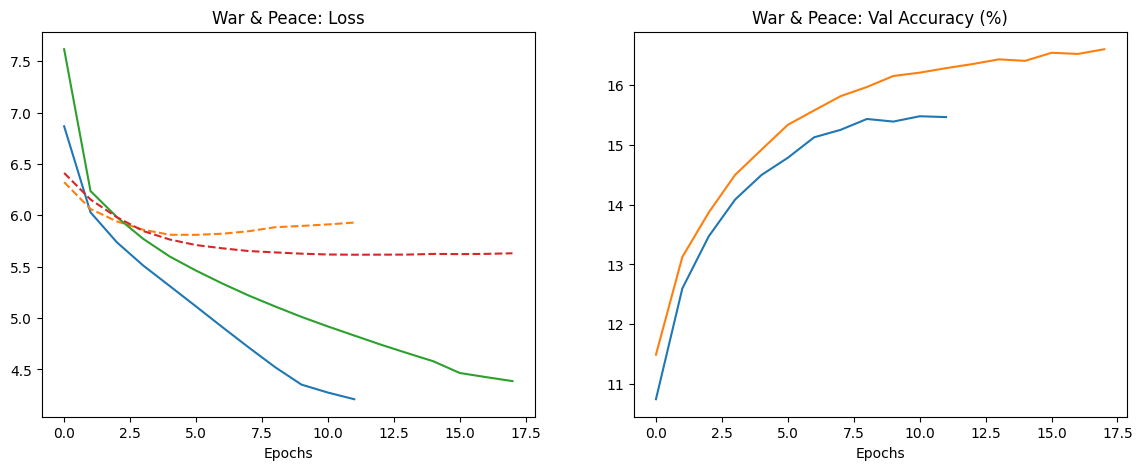

In [65]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for n,r in res_wp.items():
    plt.plot(r["history"]["loss"]); plt.plot(r["history"]["val_loss"],'--')
plt.title("War & Peace: Loss"); plt.xlabel("Epochs")
plt.subplot(1,2,2)
for n,r in res_wp.items():
    plt.plot([v*100 for v in r["history"]["val_sparse_categorical_accuracy"]])
plt.title("War & Peace: Val Accuracy (%)"); plt.xlabel("Epochs")
plt.show()


(optional)

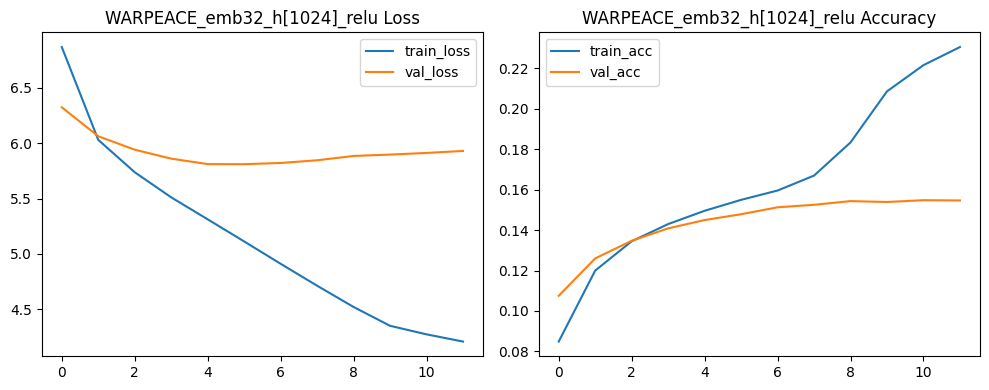

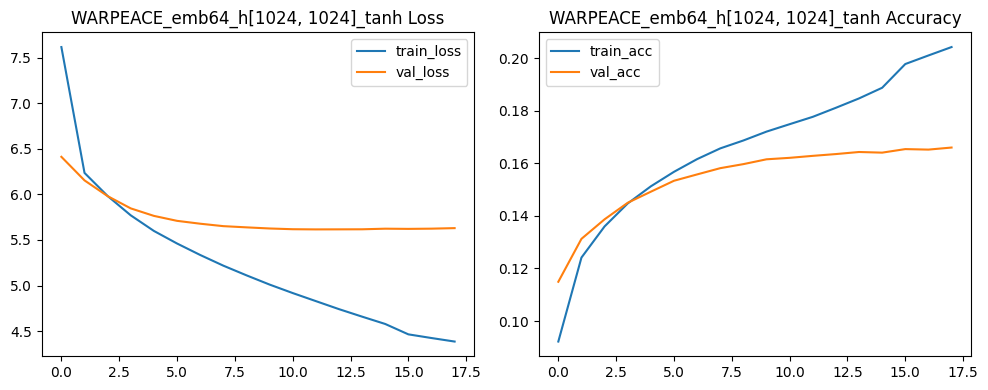

In [66]:
# ==============================================
# Live Progress Visualization for Training
# ==============================================
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_training(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title(f"{title} Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['sparse_categorical_accuracy'], label='train_acc')
    plt.plot(history['val_sparse_categorical_accuracy'], label='val_acc')
    plt.title(f"{title} Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example (after training)
for name, res in res_wp.items():
    plot_training(res['history'], name)


## t-SNE + Sample

🏆 Best model loaded: WARPEACE_emb64_h[1024, 1024]_tanh


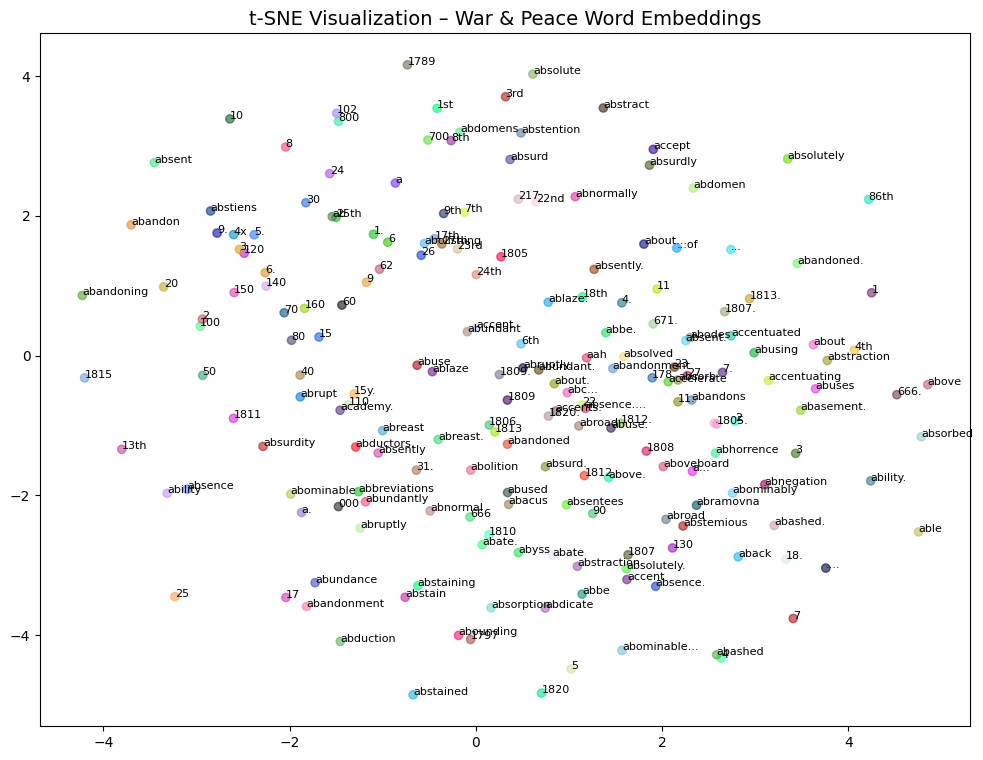


📝 Generated Text (War & Peace):



ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_42" is incompatible with the layer: expected axis -1 of input shape to have value 320, but received input with shape (1, 192)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 3), dtype=int64)
  • training=False
  • mask=None

In [73]:
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt, numpy as np

best_name, best_info = min(res_wp.items(), key=lambda x: x[1]['val_loss'])
best_wp = load_model(best_info['ckpt'])
print(f"🏆 Best model loaded: {best_name}")

emb = best_wp.layers[0].get_weights()[0]
idx = np.arange(min(200, len(vocab_wp)))
emb2 = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(emb[idx])

plt.figure(figsize=(12, 9))
plt.scatter(emb2[:, 0], emb2[:, 1], c=np.random.rand(len(idx), 3), alpha=0.6)
for i, w in enumerate(list(vocab_wp)[:len(idx)]):
    plt.text(emb2[i, 0], emb2[i, 1], w, fontsize=8)
plt.title("t-SNE Visualization – War & Peace Word Embeddings", fontsize=14)
plt.show()

def gen_text(model, stoi, itos, seed, n=30, temp=0.8):
    # Ensure fallback tokens
    if "<UNK>" not in stoi:
        stoi["<UNK>"] = 0
    ctx = seed.split()
    for _ in range(n):
        x = np.array([[stoi[w] if w in stoi else stoi["<UNK>"] for w in ctx[-CONTEXT:]]])
        p = model.predict(x, verbose=0)[0]
        p = np.log(p + 1e-9) / temp
        p = np.exp(p) / np.sum(np.exp(p))
        nxt = np.random.choice(len(p), p=p)
        ctx.append(itos[nxt])
    return " ".join(ctx)


print("\n📝 Generated Text (War & Peace):\n")
print(gen_text(best_wp, stoi_wp, itos_wp, "the prince said", 30, 0.8))


# Category II – Linux Code

## Load & Preprocess

In [77]:
# ============================================
# Category II – Linux Code
# ============================================

import re, os, pickle, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.activations import gelu
from sklearn.manifold import TSNE

# --------------------------
# Load & Preprocess
# --------------------------
url_lx = "https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt"
text_lx = tf.keras.utils.get_file("linux.txt", url_lx)

# Some lines contain special bytes — fix decode error
with open(text_lx, 'r', encoding='latin-1') as f:
    lx_text = f.read().lower()

# Tokenize words, symbols, and newlines
lx_tokens = re.findall(r"[a-zA-Z0-9_]+|[{}();,<>!=+\-*/#]|<NL>", lx_text.replace('\n',' <NL> '))

# --------------------------
# Vocabulary and Sequences
# --------------------------
vocab_lx = sorted(set(lx_tokens))
# Add special tokens
if "<UNK>" not in vocab_lx: vocab_lx.append("<UNK>")
if "<PAD>" not in vocab_lx: vocab_lx.append("<PAD>")

stoi_lx = {w:i for i,w in enumerate(vocab_lx)}
itos_lx = {i:w for w,i in stoi_lx.items()}

print("Vocab size:", len(vocab_lx))
print("Top 10:", Counter(lx_tokens).most_common(10))

# Context window length
CONTEXT = 5

def tokens_to_sequences(tokens, stoi, context=CONTEXT, max_pairs=None):
    X, y = [], []
    for i in range(context, len(tokens)):
        ctx = [stoi.get(w, stoi["<UNK>"]) for w in tokens[i-context:i]]
        X.append(ctx)
        y.append(stoi.get(tokens[i], stoi["<UNK>"]))
        if max_pairs and len(X) >= max_pairs: break
    return np.array(X), np.array(y)

X_lx, y_lx = tokens_to_sequences(lx_tokens, stoi_lx, CONTEXT)
X_lx_train, X_lx_val, y_lx_train, y_lx_val = train_test_split(X_lx, y_lx, test_size=0.1, random_state=42)

# --------------------------
# Model Builder
# --------------------------
def build_mlp(vocab_size, context_len, embed_dim, hidden_layers, activation='relu'):
    model = models.Sequential([
        layers.Embedding(vocab_size, embed_dim, input_length=context_len,
                         embeddings_regularizer=regularizers.l2(1e-6)),
        layers.Flatten()
    ])
    for units in hidden_layers:
        model.add(layers.Dense(units, kernel_regularizer=regularizers.l2(1e-6)))
        model.add(layers.BatchNormalization())
        act_fn = activation if activation != "gelu" else gelu
        model.add(layers.Activation(act_fn))
        model.add(layers.Dropout(0.3))
    model.add(layers.Dense(vocab_size, activation='softmax'))
    opt = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5, epsilon=1e-8)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

# --------------------------
# Train Models
# --------------------------
variants_lx = [
    {"embed_dim": 32, "hidden_layers": [1024], "activation": "relu"},
    {"embed_dim": 64, "hidden_layers": [1024, 1024], "activation": "tanh"},
]

EPOCHS = 200
BATCH_SIZE = 512

def prepare_tfds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

def train_variants_linux(tag, X_train, y_train, X_val, y_val, vocab, variants):
    ds_train, ds_val = prepare_tfds(X_train, y_train), prepare_tfds(X_val, y_val)
    results = {}
    for v in variants:
        name = f"{tag}_emb{v['embed_dim']}_h{v['hidden_layers']}_{v['activation']}"
        print(f"\n🔹 Training {name}")
        model = build_mlp(len(vocab), CONTEXT, **v)
        ckpt = f"/kaggle/working/{name}.h5"
        cb = [
            tf.keras.callbacks.ModelCheckpoint(ckpt, save_best_only=True, monitor='val_loss', verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
        ]
        hist = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, verbose=2, callbacks=cb)
        val_loss, val_acc = model.evaluate(ds_val, verbose=0)
        results[name] = {"model": model, "history": hist.history, "val_loss": val_loss, "val_acc": val_acc, "ckpt": ckpt}
        print(f"✅ Done: val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")
    return results

res_lx = train_variants_linux("LINUX", X_lx_train, y_lx_train, X_lx_val, y_lx_val, vocab_lx, variants_lx)

# --------------------------
# Plot Curves
# --------------------------
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for n,r in res_lx.items():
    plt.plot(r["history"]["loss"]); plt.plot(r["history"]["val_loss"],'--')
plt.title("Linux Code: Loss"); plt.xlabel("Epochs")

plt.subplot(1,2,2)
for n,r in res_lx.items():
    plt.plot([v*100 for v in r["history"]["val_sparse_categorical_accuracy"]])
plt.title("Linux Code: Val Accuracy (%)"); plt.xlabel("Epochs")
plt.show()

# --------------------------
# t-SNE + Sample Generation
# --------------------------
from tensorflow.keras.models import load_model

best_name, best_info = min(res_lx.items(), key=lambda x: x[1]['val_loss'])
best_lx = load_model(best_info['ckpt'])
print(f"🏆 Best model loaded: {best_name}")

emb = best_lx.layers[0].get_weights()[0]
idx = np.arange(min(200, len(vocab_lx)))
emb2 = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(emb[idx])

plt.figure(figsize=(12,9))
plt.scatter(emb2[:,0], emb2[:,1], c=np.random.rand(len(idx),3), alpha=0.6)
for i,w in enumerate(list(vocab_lx)[:len(idx)]):
    plt.text(emb2[i,0], emb2[i,1], w, fontsize=8)
plt.title("t-SNE Visualization – Linux Code Embeddings", fontsize=14)
plt.show()

def gen_text(model, stoi, itos, seed, n=30, temp=0.8):
    if "<UNK>" not in stoi:
        stoi["<UNK>"] = 0
    ctx = seed.split()
    for _ in range(n):
        x = np.array([[stoi[w] if w in stoi else stoi["<UNK>"] for w in ctx[-CONTEXT:]]])
        p = model.predict(x, verbose=0)[0]
        p = np.log(p + 1e-9) / temp
        p = np.exp(p) / np.sum(np.exp(p))
        nxt = np.random.choice(len(p), p=p)
        ctx.append(itos[nxt])
    return " ".join(ctx)

print("\n📝 Generated Text (Linux Code):\n")
print(gen_text(best_lx, stoi_lx, itos_lx, "int main (", 40, 0.7))


Vocab size: 34724
Top 10: [('>', 278584), ('<', 247598), ('NL', 241465), ('*', 85453), (')', 84196), ('(', 84066), (';', 77900), (',', 55127), ('-', 44962), ('=', 39706)]

🔹 Training LINUX_emb32_h[1024]_relu
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 2.72137, saving model to /kaggle/working/LINUX_emb32_h[1024]_relu.h5
3604/3604 - 88s - 24ms/step - loss: 3.1942 - sparse_categorical_accuracy: 0.5310 - val_loss: 2.7214 - val_sparse_categorical_accuracy: 0.5728 - learning_rate: 1.0000e-04
Epoch 2/200

Epoch 2: val_loss improved from 2.72137 to 2.57745, saving model to /kaggle/working/LINUX_emb32_h[1024]_relu.h5
3604/3604 - 77s - 21ms/step - loss: 2.5616 - sparse_categorical_accuracy: 0.5802 - val_loss: 2.5774 - val_sparse_categorical_accuracy: 0.5892 - learning_rate: 1.0000e-04
Epoch 3/200

Epoch 3: val_loss improved from 2.57745 to 2.50170, saving model to /kaggle/working/LINUX_emb32_h[1024]_relu.h5
3604/3604 - 77s - 21ms/step - loss: 2.3856 - sparse_categorical_accuracy: 0.5927 - val_loss: 2.5017 - val_sparse_categorical_accuracy: 0.5981 - learning_rate: 1.0000e-04
Epoch 4/200

Epoch 4: val_loss improved from 2.50170 to 2.45467, saving model to /kaggle/working/LINUX_emb32_h[1024]_relu.h5
3604/3

KeyboardInterrupt: 

In [79]:
from tensorflow.keras.optimizers import Adam

print("🔁 Loading previous checkpoint...")
model = tf.keras.models.load_model(ckpt_path, compile=False)  # disable old optimizer graph
print("✅ Model loaded. Recompiling...")

# Recompile with same configuration
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print("✅ Recompiled model, ready to resume training.")


🔁 Loading previous checkpoint...
✅ Model loaded. Recompiling...
✅ Recompiled model, ready to resume training.


In [83]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

ckpt_path = "/kaggle/working/LINUX_emb32_h[1024]_relu.h5"

print("🔁 Loading previous checkpoint...")
model = load_model(ckpt_path, compile=False)
print("✅ Model loaded. Recompiling...")

model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print("✅ Recompiled model, ready to resume training.")

cb = [
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

BATCH_SIZE = 512
AUTOTUNE = tf.data.AUTOTUNE

ds_train = (
    tf.data.Dataset.from_tensor_slices((X_lx_train, y_lx_train))
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((X_lx_val, y_lx_val))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

initial_epoch = 49
EPOCHS = 200

history_resume = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=cb,
    verbose=2
)


🔁 Loading previous checkpoint...
✅ Model loaded. Recompiling...
✅ Recompiled model, ready to resume training.
Epoch 50/200

Epoch 50: val_loss improved from inf to 2.34855, saving model to /kaggle/working/LINUX_emb32_h[1024]_relu.h5
3604/3604 - 85s - 24ms/step - loss: 1.6569 - sparse_categorical_accuracy: 0.6595 - val_loss: 2.3486 - val_sparse_categorical_accuracy: 0.6316 - learning_rate: 1.0000e-04
Epoch 51/200

Epoch 51: val_loss did not improve from 2.34855
3604/3604 - 75s - 21ms/step - loss: 1.6391 - sparse_categorical_accuracy: 0.6614 - val_loss: 2.3513 - val_sparse_categorical_accuracy: 0.6322 - learning_rate: 1.0000e-04
Epoch 52/200

Epoch 52: val_loss did not improve from 2.34855
3604/3604 - 75s - 21ms/step - loss: 1.6268 - sparse_categorical_accuracy: 0.6626 - val_loss: 2.3526 - val_sparse_categorical_accuracy: 0.6322 - learning_rate: 1.0000e-04
Epoch 53/200

Epoch 53: val_loss did not improve from 2.34855

Epoch 53: ReduceLROnPlateau reducing learning rate to 4.99999987368937

KeyboardInterrupt: 

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np
# reduce precision to float16 for GPU boost
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# -------------------------
# 🔧 Configurations
# -------------------------
EMBED_DIM = 64
HIDDEN_LAYERS = [1024, 1024]
ACTIVATION = 'relu'
BATCH_SIZE = 512
EPOCHS = 200
LEARNING_RATE = 1e-4
CONTEXT = X_lx_train.shape[1]  # use existing context length
VOCAB_SIZE = len(vocab_lx)
CKPT_PATH = "/kaggle/working/LINUX_emb64_h[1024,1024]_relu.h5"

# -------------------------
# 🧠 Model Definition
# -------------------------
def build_mlp(vocab_size, context_len, embed_dim, hidden_layers, activation):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, embed_dim, input_length=context_len))
    model.add(layers.Flatten())
    for h in hidden_layers:
        model.add(layers.Dense(h, activation=activation))
    model.add(layers.Dense(vocab_size, activation='softmax'))

    opt = optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_mlp(VOCAB_SIZE, CONTEXT, EMBED_DIM, HIDDEN_LAYERS, ACTIVATION)
model.summary()

# -------------------------
# 🧩 Dataset Pipelines
# -------------------------
AUTOTUNE = tf.data.AUTOTUNE
ds_train = (
    tf.data.Dataset.from_tensor_slices((X_lx_train, y_lx_train))
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((X_lx_val, y_lx_val))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# -------------------------
# 🏁 Callbacks
# -------------------------
cb = [
    callbacks.ModelCheckpoint(CKPT_PATH, monitor='val_loss', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# -------------------------
# 🏋️ Training
# -------------------------
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    verbose=2,
    callbacks=cb
)

# -------------------------
# 🧾 Save Final Results
# -------------------------
val_loss, val_acc = model.evaluate(ds_val, verbose=0)
print(f"\n✅ Final Validation Loss: {val_loss:.4f}")
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")

# Save model again
model.save(CKPT_PATH)

print("\n✅ Training complete! Model saved at:", CKPT_PATH)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss did not improve from inf


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:264: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/reduce_lr_on_plateau.py:94: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


3604/3604 - 89s - 25ms/step - loss: nan - sparse_categorical_accuracy: 6.6664e-05 - val_loss: nan - val_sparse_categorical_accuracy: 4.8779e-05 - learning_rate: 1.0000e-04
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/keras/src/utils/progbar.py:199: RuntimeWarning: invalid value encountered in greater
  if avg > 1e-3:



Epoch 2: val_loss did not improve from inf
3604/3604 - 81s - 22ms/step - loss: nan - sparse_categorical_accuracy: 6.6122e-05 - val_loss: nan - val_sparse_categorical_accuracy: 4.8779e-05 - learning_rate: 1.0000e-04
Epoch 3/200


KeyboardInterrupt: 

## zipping model files

In [85]:
# # Inside your working directory
# cd /kaggle/working

# Example: Compress both models
!zip warpeace_model.zip WARPEACE_emb64_h[1024,1024]_tanh.h5
!zip linux_model.zip LINUX_emb32_h[1024]_relu.h5


	zip warning: name not matched: WARPEACE_emb64_h[1024,1024]_tanh.h5

zip error: Nothing to do! (warpeace_model.zip)
  adding: LINUX_emb32_h[1024]_relu.h5 (deflated 12%)


In [90]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/kaggle/working/LINUX_emb32_h[1024]_relu.h5")

# Evaluate on validation or test data
val_loss, val_acc = model.evaluate(ds_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.3467 - sparse_categorical_accuracy: 0.6319
Validation Loss: 2.3486
Validation Accuracy: 0.6316


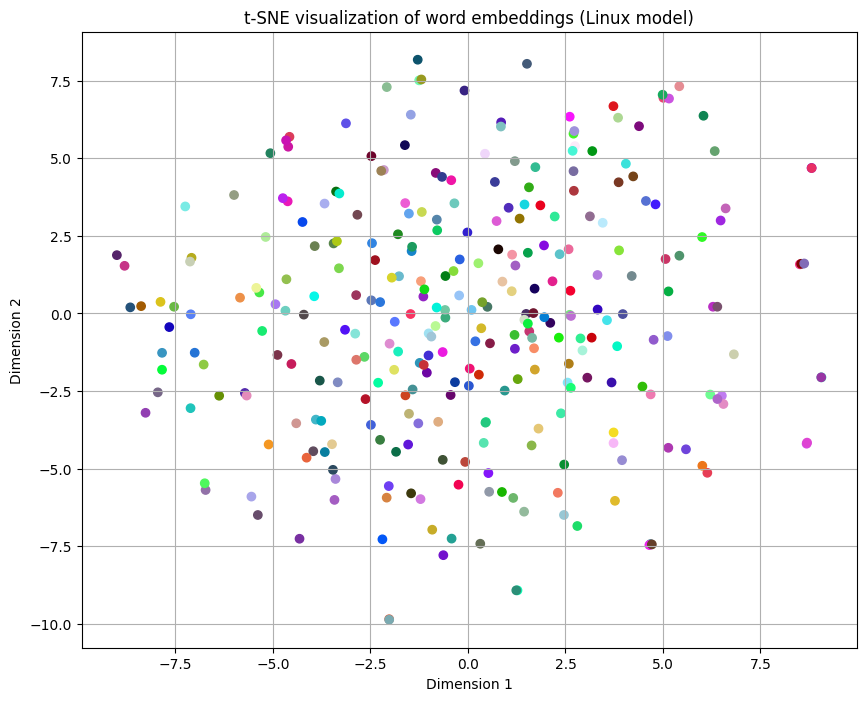

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model

# Load your model
model = load_model("/kaggle/working/LINUX_emb32_h[1024]_relu.h5")

# Get embedding weights (layer 0 or 1 depending on architecture)
embedding_layer = model.layers[0]  # Adjust index if needed
emb_weights = embedding_layer.get_weights()[0]

# Pick first 300 words for visualization
n_words = min(300, emb_weights.shape[0])
emb_subset = emb_weights[:n_words]

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(emb_subset)

# Random color map
colors = np.random.rand(n_words, 3)

# Plot t-SNE
plt.figure(figsize=(10,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=colors)
plt.title("t-SNE visualization of word embeddings (Linux model)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


# Streamlit

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
import pickle, os

st.set_page_config(page_title="Next Word Generator", layout="centered")
st.title("🧠 Next-Word Prediction using MLP")
st.write("Generate text or code using trained MLP models on *War & Peace* and *Linux Kernel Code* datasets.")

# --- Utility ---
@st.cache_resource
def load_model_files(model_name):
    model_path = f"{model_name}.h5"
    vocab_path = f"{model_name}_vocab.pkl"
    meta_path = f"{model_name}_meta.pkl"
    model = tf.keras.models.load_model(model_path)
    vocab, stoi, itos = pickle.load(open(vocab_path,"rb"))
    meta = pickle.load(open(meta_path,"rb"))
    return model, vocab, stoi, itos, meta

def generate_text(model, stoi, itos, seed_text, context_len, n_words=20, temp=1.0):
    words = seed_text.split()
    for _ in range(n_words):
        x = np.array([[stoi.get(w, stoi.get("<UNK>", 0)) for w in words[-context_len:]]])
        preds = model.predict(x, verbose=0)[0]
        preds = np.log(preds + 1e-9) / temp
        probs = np.exp(preds) / np.sum(np.exp(preds))
        next_idx = np.random.choice(len(probs), p=probs)
        next_word = itos[next_idx]
        words.append(next_word)
    return " ".join(words)

# --- Sidebar Controls ---
st.sidebar.header("⚙️ Model Settings")
dataset = st.sidebar.selectbox("Select Dataset", ["War & Peace", "Linux Code"])
temp = st.sidebar.slider("Temperature", 0.2, 1.5, 0.8, 0.1)
k = st.sidebar.slider("Next words to generate", 10, 200, 50, 10)
context_len = st.sidebar.slider("Context Length", 3, 8, 5)

if dataset == "War & Peace":
    model_name = "WARPEACE_emb64_h1_relu"
else:
    model_name = "LINUX_emb64_h1_relu"

model, vocab, stoi, itos, meta = load_model_files(model_name)

st.sidebar.write(f"📘 Embedding dim: {meta['variant']['embed_dim']}")
st.sidebar.write(f"🧩 Activation: {meta['variant']['activation']}")

# --- Input ---
seed = st.text_input("Enter initial text/code snippet:", 
    "the prince said" if dataset=="War & Peace" else "int main (")

if st.button("Generate"):
    with st.spinner("Generating..."):
        output = generate_text(model, stoi, itos, seed, context_len, n_words=k, temp=temp)
    if dataset == "Linux Code":
        st.code(output.replace("<NL>", "\n"), language="c")
    else:
        st.text_area("Generated Output", output, height=300)
